# Quickstart to Parcels


Welcome to a quick tutorial on Parcels. This is meant to get you started with the code, and give you a flavour of some of the key features of Parcels.


In this tutorial, we will first cover how to run a set of particles [from a very simple idealised field](#Running-particles-in-an-idealised-field). We will show how easy it is to run particles in [time-backward mode](#Running-particles-in-backward-time). Then, we will show how to [add custom behaviour](#Adding-a-custom-behaviour-kernel) to the particles. Then, we will show how to [run particles in a set of NetCDF files from external data](#Reading-in-data-from-arbritrary-NetCDF-files). Then, we will show how to use particles to [sample a field](#Sampling-a-Field-with-Particles) such as temperature or sea surface height. And finally, we will show how to [write a kernel that tracks the distance travelled by the particles](#calculating-distance-travelled).


Let's start with importing the relevant packages.


In [1]:
import math
from datetime import timedelta
from operator import attrgetter

import matplotlib.pyplot as plt
import numpy as np
import trajan as ta
import xarray as xr
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

import parcels

## Running particles in an idealised field


The first step to running particles with Parcels is to define a `FieldSet` object, which is simply a collection of hydrodynamic fields. In this first case, we use a simple flow of two idealised moving eddies. That field can be downloaded using the `download_example_dataset()` function that comes with Parcels. Since we know that the files are in what's called Parcels FieldSet format, we can call these files using the function `FieldSet.from_parcels()`.


In [2]:
example_dataset_folder = parcels.download_example_dataset("MovingEddies_data")

fieldset = parcels.FieldSet.from_parcels(f"{example_dataset_folder}/moving_eddies")

print(fieldset)

<FieldSet>
    fields:
        <Field>
            name            : 'U'
            grid            : RectilinearZGrid(lon=array([ 0.00,  2010.05,  4020.10, ...,  395979.91,  397989.94,  400000.00], dtype=float32), lat=array([ 0.00,  2005.73,  4011.46, ...,  695988.56,  697994.25,  700000.00], dtype=float32), time=array([ 0.00,  86400.00,  172800.00, ...,  432000.00,  518400.00,  604800.00]), time_origin=0.0, mesh='flat')
            extrapolate time: False
            time_periodic   : False
            gridindexingtype: 'nemo'
            to_write        : False
        <Field>
            name            : 'V'
            grid            : RectilinearZGrid(lon=array([ 0.00,  2010.05,  4020.10, ...,  395979.91,  397989.94,  400000.00], dtype=float32), lat=array([ 0.00,  2005.73,  4011.46, ...,  695988.56,  697994.25,  700000.00], dtype=float32), time=array([ 0.00,  86400.00,  172800.00, ...,  432000.00,  518400.00,  604800.00]), time_origin=0.0, mesh='flat')
            extrapolate 

The `fieldset` can then be visualized with e.g. `matplotlib.pyplot.pcolormesh()`. To show the zonal velocity (`U`), give the commands below. Note that we first have to load the fieldset with `fieldset.computeTimeChunk()` to load the first time frame of the fieldset.

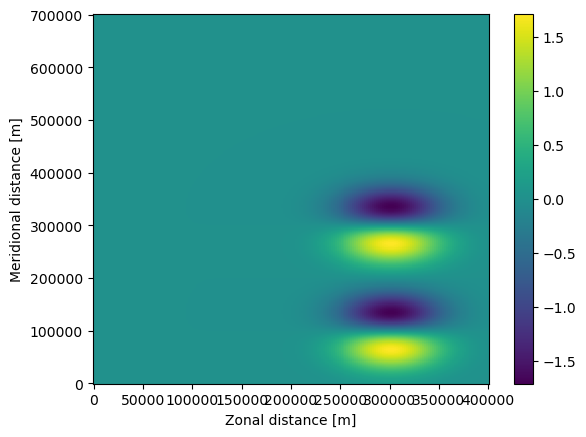

In [3]:
fieldset.computeTimeChunk()

plt.pcolormesh(fieldset.U.grid.lon, fieldset.U.grid.lat, fieldset.U.data[0, :, :])
plt.xlabel("Zonal distance [m]")
plt.ylabel("Meridional distance [m]")
plt.colorbar()
plt.show()

The next step is to define a `ParticleSet`. In this case, we start 2 particles at locations (330km, 100km) and (330km, 280km) using the `from_list` constructor method, that are advected on the `fieldset` we defined above. Note that we use `Particle` as `pclass`, which is the default choice for particle advection in Parcels.


In [4]:
pset = parcels.ParticleSet.from_list(
    fieldset=fieldset,  # the fields on which the particles are advected
    pclass=parcels.Particle,  # the type of particles (Particle or a custom class)
    lon=[3.3e5, 3.3e5],  # a vector of release longitudes
    lat=[1e5, 2.8e5],  # a vector of release latitudes
)

Print the `ParticleSet` to see where they start.


In [5]:
print(pset)

<ParticleSet>
    fieldset   :
        <FieldSet>
            fields:
                <Field>
                    name            : 'U'
                    grid            : RectilinearZGrid(lon=array([ 0.00,  2010.05,  4020.10, ...,  395979.91,  397989.94,  400000.00], dtype=float32), lat=array([ 0.00,  2005.73,  4011.46, ...,  695988.56,  697994.25,  700000.00], dtype=float32), time=array([ 0.00,  86400.00]), time_origin=0.0, mesh='flat')
                    extrapolate time: False
                    time_periodic   : False
                    gridindexingtype: 'nemo'
                    to_write        : False
                <Field>
                    name            : 'V'
                    grid            : RectilinearZGrid(lon=array([ 0.00,  2010.05,  4020.10, ...,  395979.91,  397989.94,  400000.00], dtype=float32), lat=array([ 0.00,  2005.73,  4011.46, ...,  695988.56,  697994.25,  700000.00], dtype=float32), time=array([ 0.00,  86400.00]), time_origin=0.0, mesh='flat')
   

This output shows for each particle the (longitude, latitude, depth, time). Note that in this case the time is `not_yet_set`, that is because we didn't specify a `time` when we defined the `pset`.


To plot the positions of these particles on the zonal velocity, use the following command.


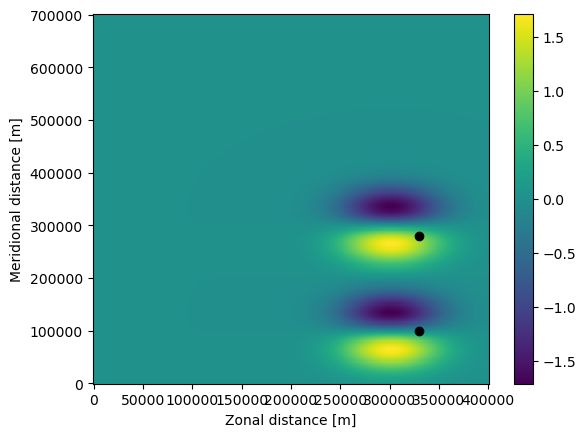

In [6]:
plt.pcolormesh(fieldset.U.grid.lon, fieldset.U.grid.lat, fieldset.U.data[0, :, :])
plt.xlabel("Zonal distance [m]")
plt.ylabel("Meridional distance [m]")
plt.colorbar()

plt.plot(pset.lon, pset.lat, "ko")
plt.show()

We can now create `ParticleFile` objects to store the output of the particles. We will store the output at an interval of 1 hour in a `zarr` file called `EddyParticles.zar`. See the [Working with Parcels output tutorial](https://docs.oceanparcels.org/en/latest/examples/tutorial_output.html) for more information on the `zarr` format.

In [7]:
output_file = pset.ParticleFile(
    name="EddyParticles.zarr",  # the file name
    outputdt=timedelta(hours=1),  # the time step of the outputs
)

print(output_file)

ParticleFile(name='EddyParticles.zarr', particleset=<parcels.particleset.ParticleSet object at 0x151b4c110>, outputdt=3600.0, chunks=None, create_new_zarrfile=True)


The final step is to run (or 'execute') the `ParticelSet`. We run the particles using the `AdvectionRK4` kernel, which is a 4th order Runge-Kutte implementation that comes with Parcels. We run the particles for 6 days (using the `timedelta` function from `datetime`), at an RK4 timestep of 5 minutes. Because `time` was `not_yet_set`, the particles will be advected from the first date available in the `fieldset`, which is the default behaviour.


In [8]:
pset.execute(
    parcels.AdvectionRK4,  # the kernel (which defines how particles move)
    runtime=timedelta(days=6),  # the total length of the run
    dt=timedelta(minutes=5),  # the timestep of the kernel
    output_file=output_file,
)

INFO: Output files are stored in EddyParticles.zarr.
100%|██████████| 518400.0/518400.0 [00:07<00:00, 71259.58it/s]


The code should have run, which can be confirmed by printing and plotting the `ParticleSet` again.


<ParticleSet>
    fieldset   :
        <FieldSet>
            fields:
                <Field>
                    name            : 'U'
                    grid            : RectilinearZGrid(lon=array([ 0.00,  2010.05,  4020.10, ...,  395979.91,  397989.94,  400000.00], dtype=float32), lat=array([ 0.00,  2005.73,  4011.46, ...,  695988.56,  697994.25,  700000.00], dtype=float32), time=array([ 432000.00,  518400.00]), time_origin=0.0, mesh='flat')
                    extrapolate time: False
                    time_periodic   : False
                    gridindexingtype: 'nemo'
                    to_write        : False
                <Field>
                    name            : 'V'
                    grid            : RectilinearZGrid(lon=array([ 0.00,  2010.05,  4020.10, ...,  395979.91,  397989.94,  400000.00], dtype=float32), lat=array([ 0.00,  2005.73,  4011.46, ...,  695988.56,  697994.25,  700000.00], dtype=float32), time=array([ 432000.00,  518400.00]), time_origin=0.0, mesh

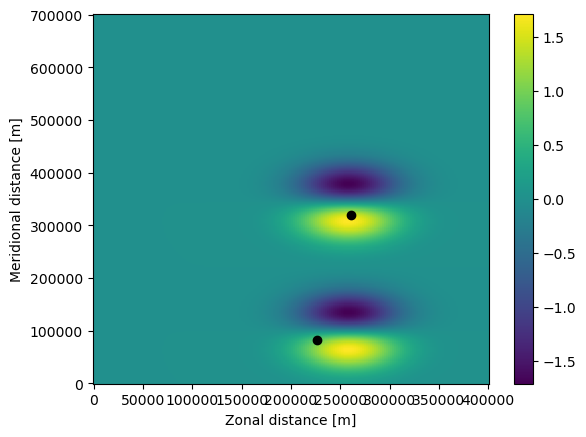

In [9]:
print(pset)

plt.pcolormesh(fieldset.U.grid.lon, fieldset.U.grid.lat, fieldset.U.data[0, :, :])
plt.xlabel("Zonal distance [m]")
plt.ylabel("Meridional distance [m]")
plt.colorbar()

plt.plot(pset.lon, pset.lat, "ko")
plt.show()

Note that both the particles (the black dots) and the `U` field have moved in the plot above. Also, the `time` of the particles is now 518400 seconds, which is 6 days.


The trajectories in the `EddyParticles.zarr` file can be quickly plotted using `xr.open_zarr()` (note that the `lon` and `lat` arrays need to be transposed with `.T`).


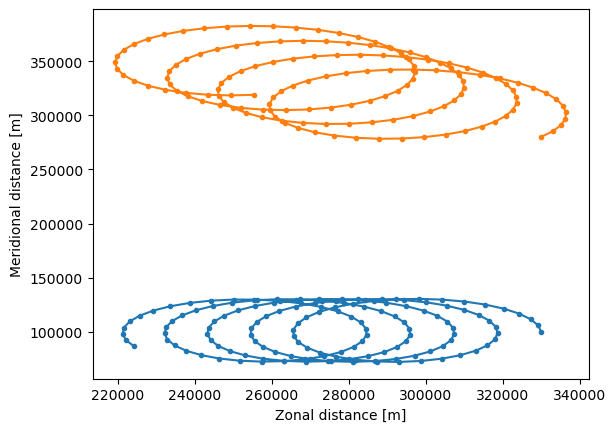

In [10]:
ds = xr.open_zarr("EddyParticles.zarr")

plt.plot(ds.lon.T, ds.lat.T, ".-")
plt.xlabel("Zonal distance [m]")
plt.ylabel("Meridional distance [m]")
plt.show()

Using the `FuncAnimation()` method, we can show the trajectories as an animation and watch the particles go!


In [11]:
%%capture
fig = plt.figure(figsize=(7, 5), constrained_layout=True)
ax = fig.add_subplot()

ax.set_ylabel("Meridional distance [m]")
ax.set_xlabel("Zonal distance [m]")
ax.set_xlim(0, 4e5)
ax.set_ylim(0, 7e5)

# show only every fifth output (for speed in creating the animation)
timerange = np.unique(ds["time"].values)[::5]

# Indices of the data where time = 0
time_id = np.where(ds["time"] == timerange[0])

sc = ax.scatter(ds["lon"].values[time_id], ds["lat"].values[time_id])

t = str(timerange[0].astype("timedelta64[h]"))
title = ax.set_title(f"Particles at t = {t}")


def animate(i):
    t = str(timerange[i].astype("timedelta64[h]"))
    title.set_text(f"Particles at t = {t}")

    time_id = np.where(ds["time"] == timerange[i])
    sc.set_offsets(np.c_[ds["lon"].values[time_id], ds["lat"].values[time_id]])


anim = FuncAnimation(fig, animate, frames=len(timerange), interval=100)

In [12]:
HTML(anim.to_jshtml())

## Running particles in backward time


Running particles in backward time is extremely simple: just provide a `dt` < 0.


In [13]:
output_file = pset.ParticleFile(
    name="EddyParticles_Bwd.zarr",  # the file name
    outputdt=timedelta(hours=1),  # the time step of the outputs
)
pset.execute(
    parcels.AdvectionRK4,
    dt=-timedelta(minutes=5),  # negative timestep for backward run
    runtime=timedelta(days=6),  # the run time
    output_file=output_file,
)

INFO: Output files are stored in EddyParticles_Bwd.zarr.
100%|██████████| 518400.0/518400.0 [00:06<00:00, 75549.14it/s]


Now print the particles again, and see that they (except for some round-off errors) returned to their original position.


<ParticleSet>
    fieldset   :
        <FieldSet>
            fields:
                <Field>
                    name            : 'U'
                    grid            : RectilinearZGrid(lon=array([ 0.00,  2010.05,  4020.10, ...,  395979.91,  397989.94,  400000.00], dtype=float32), lat=array([ 0.00,  2005.73,  4011.46, ...,  695988.56,  697994.25,  700000.00], dtype=float32), time=array([ 0.00,  86400.00]), time_origin=0.0, mesh='flat')
                    extrapolate time: False
                    time_periodic   : False
                    gridindexingtype: 'nemo'
                    to_write        : False
                <Field>
                    name            : 'V'
                    grid            : RectilinearZGrid(lon=array([ 0.00,  2010.05,  4020.10, ...,  395979.91,  397989.94,  400000.00], dtype=float32), lat=array([ 0.00,  2005.73,  4011.46, ...,  695988.56,  697994.25,  700000.00], dtype=float32), time=array([ 0.00,  86400.00]), time_origin=0.0, mesh='flat')
   

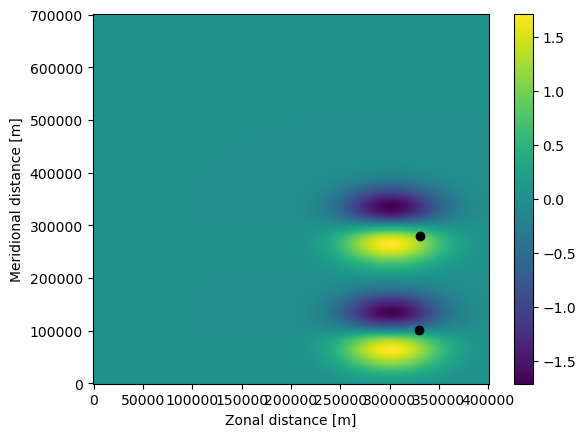

In [14]:
print(pset)

plt.pcolormesh(fieldset.U.grid.lon, fieldset.U.grid.lat, fieldset.U.data[0, :, :])
plt.xlabel("Zonal distance [m]")
plt.ylabel("Meridional distance [m]")
plt.colorbar()

plt.plot(pset.lon, pset.lat, "ko")
plt.show()

## Adding a custom behaviour kernel


A key feature of Parcels is the ability to quickly create very simple kernels, and add them to the execution. Kernels are little snippets of code that are run during exection of the particles.


In this example, we'll create a simple kernel where particles obtain an extra 2 m/s westward velocity after 1 day. Of course, this is not very realistic scenario, but it nicely illustrates the power of custom kernels.


In [15]:
def WestVel(particle, fieldset, time):
    if time > 86400:
        uvel = -2.0
        particle_dlon += uvel * particle.dt

Note that in the Kernel above, we update `particle_dlon`, and not `particle.lon` directly. This is because of the particular way in which particle locations are updated; see also the [tutorial on the particle Kernel loop](https://docs.oceanparcels.org/en/latest/examples/tutorial_kernelloop.html).

Now reset the `ParticleSet` again, and re-execute. Note that we have now changed the first argument of `pset.execute()` to be a list of `[AdvectionRK4, WestVel]`.


In [16]:
pset = parcels.ParticleSet.from_list(
    fieldset=fieldset,
    pclass=parcels.Particle,
    lon=[3.3e5, 3.3e5],
    lat=[1e5, 2.8e5],
)

output_file = pset.ParticleFile(
    name="EddyParticles_WestVel.zarr", outputdt=timedelta(hours=1)
)
pset.execute(
    [parcels.AdvectionRK4, WestVel],  # simply combine the Kernels in a list
    runtime=timedelta(days=2),
    dt=timedelta(minutes=5),
    output_file=output_file,
)

INFO: Output files are stored in EddyParticles_WestVel.zarr.
  0%|          | 0/172800.0 [00:00<?, ?it/s]

100%|██████████| 172800.0/172800.0 [00:02<00:00, 69343.28it/s]


And now plot this new trajectory file.


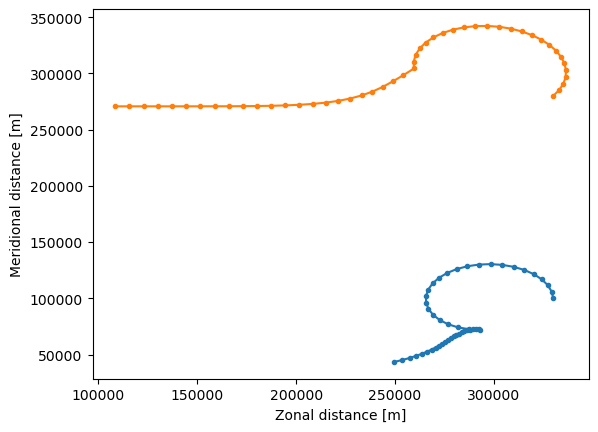

In [17]:
ds = xr.open_zarr("EddyParticles_WestVel.zarr")

plt.plot(ds.lon.T, ds.lat.T, ".-")
plt.xlabel("Zonal distance [m]")
plt.ylabel("Meridional distance [m]")
plt.show()

## Reading in data from arbritrary NetCDF files


In most cases, you will want to advect particles within pre-computed velocity fields. If these velocity fields are stored in NetCDF format, it is fairly easy to load them into the `FieldSet.from_netcdf()` function.


The `examples` directory contains a set of [GlobCurrent](http://globcurrent.ifremer.fr/products-data/products-overview) files of the region around South Africa.


First, define the names of the files containing the zonal (U) and meridional (V) velocities. You can use wildcards (`*`) and the filenames for U and V can be the same (as in this case).


In [18]:
example_dataset_folder = parcels.download_example_dataset("GlobCurrent_example_data")

filenames = {
    "U": f"{example_dataset_folder}/20*.nc",
    "V": f"{example_dataset_folder}/20*.nc",
}

Then, define a dictionary of the variables (`U` and `V`) and dimensions (`lon`, `lat` and `time`; note that in this case there is no `depth` because the GlobCurrent data is only for the surface of the ocean).


In [19]:
variables = {
    "U": "eastward_eulerian_current_velocity",
    "V": "northward_eulerian_current_velocity",
}
dimensions = {"lat": "lat", "lon": "lon", "time": "time"}

Finally, read in the fieldset using the `FieldSet.from_netcdf` function with the above-defined `filenames`, `variables` and `dimensions`.


In [20]:
fieldset = parcels.FieldSet.from_netcdf(filenames, variables, dimensions)

Now define a `ParticleSet`, in this case with 5 particle starting on a line between (28E, 33S) and (30E, 33S) using the `ParticleSet.from_line` constructor method.


In [21]:
pset = parcels.ParticleSet.from_line(
    fieldset=fieldset,
    pclass=parcels.Particle,
    size=5,  # releasing 5 particles
    start=(28, -33),  # releasing on a line: the start longitude and latitude
    finish=(30, -33),  # releasing on a line: the end longitude and latitude
)

And finally execute the `ParticleSet` for 10 days using 4th order Runge-Kutta.


In [22]:
output_file = pset.ParticleFile(
    name="GlobCurrentParticles.zarr", outputdt=timedelta(hours=6)
)
pset.execute(
    parcels.AdvectionRK4,
    runtime=timedelta(days=10),
    dt=timedelta(minutes=5),
    output_file=output_file,
)

INFO: Output files are stored in GlobCurrentParticles.zarr.
100%|██████████| 864000.0/864000.0 [00:11<00:00, 75154.85it/s]


Because the GlobCurrent data represents the 'real' ocean, we can use the [trajan](https://opendrift.github.io/trajan/index.html) package to visualize this simulation. Use `ds.traj.plot()` to plot the trajectories.


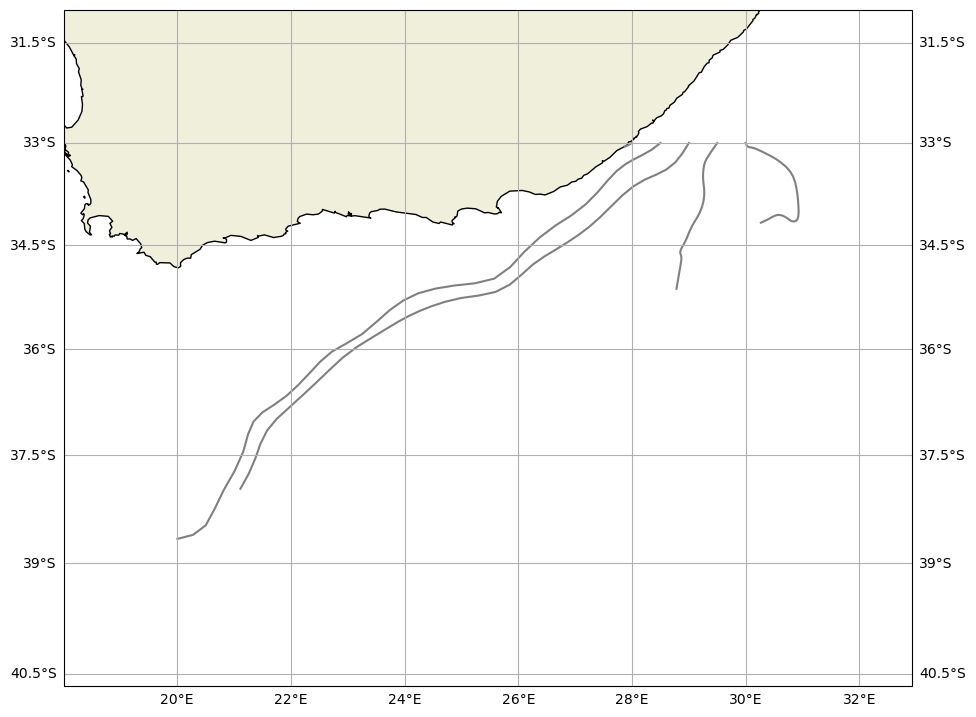

In [23]:
ds = xr.open_zarr("GlobCurrentParticles.zarr")
ds.traj.plot(margin=2)
plt.show()

## Sampling a Field with Particles


One typical use case of particle simulations is to sample a Field (such as temperature, vorticity or sea surface hight) along a particle trajectory. In Parcels, this is very easy to do, with a custom Kernel.


Let's read in another example, the flow around a Peninsula (see [Fig 2.2.3 in this document](http://archimer.ifremer.fr/doc/00157/26792/24888.pdf)), and this time also load the Pressure (`P`) field, using `extra_fields={'P': 'P'}`. Note that, because this flow does not depend on time, we need to set `allow_time_extrapolation=True` when reading in the fieldset.


In [24]:
example_dataset_folder = parcels.download_example_dataset("Peninsula_data")
fieldset = parcels.FieldSet.from_parcels(
    f"{example_dataset_folder}/peninsula",
    extra_fields={"P": "P"},
    allow_time_extrapolation=True,
)

Now define a new `Particle` class that has an extra `Variable`: the pressure. This `particle.p` can be used to store the values of the `fieldset.P` field at the particle locations.


In [25]:
SampleParticle = parcels.Particle.add_variable("p")

Now define a `ParticleSet` using the `from_line` method also used above in the GlobCurrent data. Plot the `pset` on top of a contour plot of the `P` field.


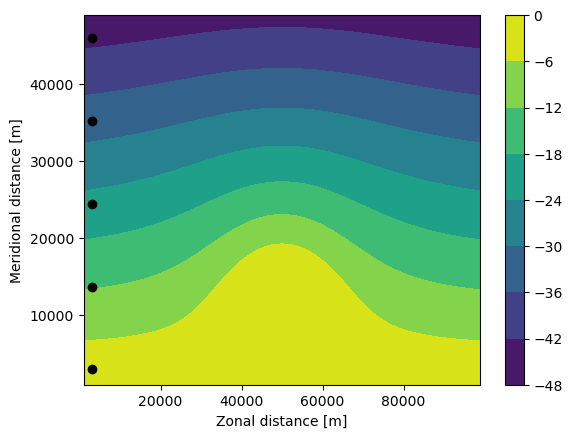

In [26]:
pset = parcels.ParticleSet.from_line(
    fieldset=fieldset,
    pclass=SampleParticle,
    start=(3000, 3000),
    finish=(3000, 46000),
    size=5,
    time=0,
)

plt.contourf(fieldset.P.grid.lon, fieldset.P.grid.lat, fieldset.P.data[0, :, :])
plt.xlabel("Zonal distance [m]")
plt.ylabel("Meridional distance [m]")
plt.colorbar()

plt.plot(pset.lon, pset.lat, "ko")
plt.show()

Now create a custom function that samples the `fieldset.P` field at the particle location.


In [27]:
def SampleP(particle, fieldset, time):
    """Custom function that samples fieldset.P at particle location"""
    particle.p = fieldset.P[time, particle.depth, particle.lat, particle.lon]

Now, execute the `pset` with a combination of the `AdvectionRK4` and `SampleP` kernels.


In [28]:
output_file = pset.ParticleFile(
    name="PeninsulaPressure.zarr", outputdt=timedelta(hours=1)
)
pset.execute(
    [parcels.AdvectionRK4, SampleP],  # list of kernels to be executed
    runtime=timedelta(hours=20),
    dt=timedelta(minutes=5),
    output_file=output_file,
)

INFO: Output files are stored in PeninsulaPressure.zarr.
  0%|          | 0/72000.0 [00:00<?, ?it/s]

100%|██████████| 72000.0/72000.0 [00:01<00:00, 64409.93it/s]


Now, plot the particle trajectories on top of the `P` field, colored by the sampled pressure. As you can see, the dots with black edges are the same color as the background pressure field, which means that the sampling worked!

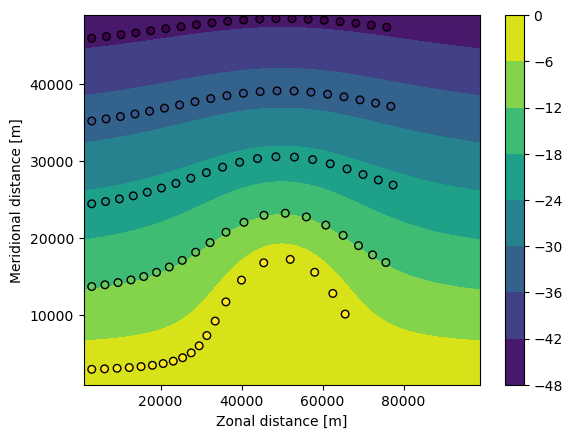

In [29]:
ds = xr.open_zarr("PeninsulaPressure.zarr")

plt.contourf(fieldset.P.grid.lon, fieldset.P.grid.lat, fieldset.P.data[0, :, :])
plt.xlabel("Zonal distance [m]")
plt.ylabel("Meridional distance [m]")
plt.colorbar()

plt.scatter(ds.lon, ds.lat, c=ds.p, s=30, cmap="viridis", edgecolors="k")
plt.show()

And see that these pressure values `p` are (within roundoff errors) the same as the pressure values before the execution of the kernels. The particles thus stay on isobars!


## Calculating distance travelled


As a second example of what custom kernels can do, we will now show how to create a kernel that logs the total distance that particles have travelled.


First, we need to add three extra variables to the Particle Class. The `distance` variable will be written to output, but the auxiliary variables `prev_lon` and `prev_lat` won't be written to output (can be controlled using the `to_write` keyword).

In [30]:
extra_vars = [
    parcels.Variable("distance", initial=0.0, dtype=np.float32),
    parcels.Variable(
        "prev_lon", dtype=np.float32, to_write=False, initial=attrgetter("lon")
    ),
    parcels.Variable(
        "prev_lat", dtype=np.float32, to_write=False, initial=attrgetter("lat")
    ),
]

DistParticle = parcels.Particle.add_variables(extra_vars)

Now define a new function `TotalDistance` that calculates the sum of Euclidean distances between the old and new locations in each RK4 step.


In [31]:
def TotalDistance(particle, fieldset, time):
    """Calculate the distance in latitudinal direction
    (using 1.11e2 kilometer per degree latitude)"""
    lat_dist = (particle.lat - particle.prev_lat) * 1.11e2
    lon_dist = (
        (particle.lon - particle.prev_lon)
        * 1.11e2
        * math.cos(particle.lat * math.pi / 180)
    )
    # Calculate the total Euclidean distance travelled by the particle
    particle.distance += math.sqrt(math.pow(lon_dist, 2) + math.pow(lat_dist, 2))

    # Set the stored values for next iteration
    particle.prev_lon = particle.lon
    particle.prev_lat = particle.lat

_Note:_ here it is assumed that the latitude and longitude are measured in degrees North and East, respectively. However, some datasets (e.g. the `MovingEddies` used above) give them measured in (kilo)meters, in which case we must _not_ include the factor `1.11e2`.


We will run the `TotalDistance` function on a `ParticleSet` containing the five particles within the `GlobCurrent` fieldset from above. Note that `pclass=DistParticle` in this case.


In [32]:
example_dataset_folder = parcels.download_example_dataset("GlobCurrent_example_data")
filenames = {
    "U": f"{example_dataset_folder}/20*.nc",
    "V": f"{example_dataset_folder}/20*.nc",
}
variables = {
    "U": "eastward_eulerian_current_velocity",
    "V": "northward_eulerian_current_velocity",
}
dimensions = {"lat": "lat", "lon": "lon", "time": "time"}
fieldset = parcels.FieldSet.from_netcdf(filenames, variables, dimensions)
pset = parcels.ParticleSet.from_line(
    fieldset=fieldset, pclass=DistParticle, size=5, start=(28, -33), finish=(30, -33)
)

Again define a new kernel to include the function written above and execute the `ParticleSet`.


In [33]:
pset.execute(
    [parcels.AdvectionRK4, TotalDistance],  # list of kernels to be executed
    runtime=timedelta(days=6),
    dt=timedelta(minutes=5),
    output_file=pset.ParticleFile(
        name="GlobCurrentParticles_Dist.zarr", outputdt=timedelta(hours=1)
    ),
)

INFO: Output files are stored in GlobCurrentParticles_Dist.zarr.
100%|██████████| 518400.0/518400.0 [00:11<00:00, 44597.13it/s]


And finally print the distance in km that each particle has travelled (note that this is also stored in the `EddyParticles_Dist.zarr` file).


In [34]:
print([p.distance for p in pset])

[13.197482, 640.92773, 543.45953, 183.60716, 172.74182]
